In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Load encoded dataset and tuned models
X_train = pd.read_csv('processed_data/X_train_encoded.csv')
X_test = pd.read_csv('processed_data/X_test_encoded.csv')
y_train = pd.read_csv('processed_data/y_train.csv').values.ravel()
y_test = pd.read_csv('processed_data/y_test.csv').values.ravel()

xgb_model = joblib.load('artifacts/tuned_models/xgboost_tuned.pkl')
lgbm_model = joblib.load('artifacts/tuned_models/lightgbm_tuned.pkl')


In [2]:
xgb_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)


In [3]:
lgbm_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': lgbm_model.feature_importances_
}).sort_values(by='Importance', ascending=False)


C:\Users\MoorthyMitturu\AppData\Local\Temp\ipykernel_31852\218359803.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


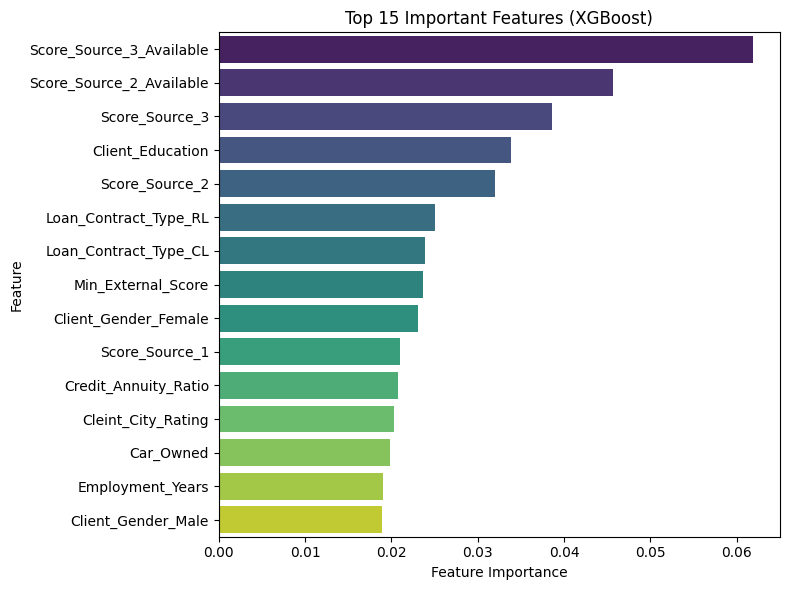

C:\Users\MoorthyMitturu\AppData\Local\Temp\ipykernel_31852\218359803.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


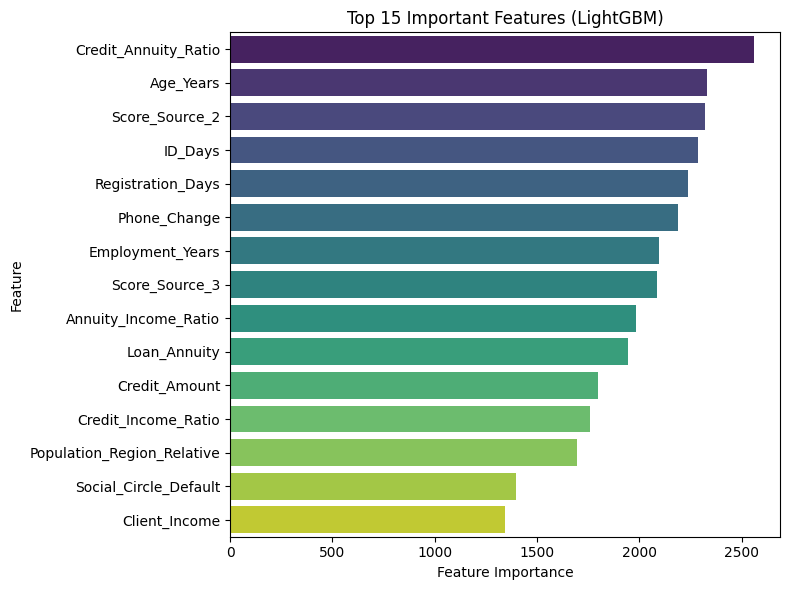

In [4]:
def plot_top_features(df, model_name, top_n=15):
    plt.figure(figsize=(8,6))
    sns.barplot(
        data=df.head(top_n),
        x='Importance',
        y='Feature',
        palette='viridis'
    )
    plt.title(f"Top {top_n} Important Features ({model_name})")
    plt.xlabel("Feature Importance")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

plot_top_features(xgb_importance, "XGBoost")
plot_top_features(lgbm_importance, "LightGBM")


In [8]:
# Convert all columns to numeric if possible
X_train_fixed = X_train.apply(pd.to_numeric, errors='coerce')
X_test_fixed  = X_test.apply(pd.to_numeric, errors='coerce')

# Check for NaNs introduced by coercion
print(f"Missing values after conversion: {X_train_fixed.isna().sum().sum()}")
X_train_fixed = X_train_fixed.fillna(0)
X_test_fixed  = X_test_fixed.fillna(0)


Missing values after conversion: 0


In [10]:
import pandas as pd
import shap
import numpy as np

# Load the encoded test data
X_test_fixed = pd.read_csv('processed_data/X_test_encoded.csv')

# ⚠️ CRITICAL FIX: Ensure all columns are numeric
print("Data types before conversion:")
print(X_test_fixed.dtypes.value_counts())

# Convert all columns to numeric
for col in X_test_fixed.columns:
    X_test_fixed[col] = pd.to_numeric(X_test_fixed[col], errors='coerce')

# Check for any NaN values introduced by conversion
if X_test_fixed.isnull().any().any():
    print("\n⚠️ NaN values found after conversion:")
    print(X_test_fixed.isnull().sum()[X_test_fixed.isnull().sum() > 0])
    # Fill NaN with 0 or appropriate value
    X_test_fixed = X_test_fixed.fillna(0)

print("\nData types after conversion:")
print(X_test_fixed.dtypes.value_counts())

# Now SHAP should work
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test_fixed)

# Create plots
shap.summary_plot(shap_values, X_test_fixed, plot_type="bar", max_display=15)
shap.summary_plot(shap_values, X_test_fixed, max_display=15)


Data types before conversion:
float64    56
Name: count, dtype: int64

Data types after conversion:
float64    56
Name: count, dtype: int64


ValueError: could not convert string to float: '[5E-1]'

In [11]:
X_test_fixed = pd.read_csv('processed_data/X_test_encoded.csv')

# Check for problematic columns
print("Checking for string/object columns:")
for col in X_test_fixed.columns:
    if X_test_fixed[col].dtype == 'object':
        print(f"  ⚠️ {col}: {X_test_fixed[col].dtype}")
        print(f"     Sample values: {X_test_fixed[col].head().tolist()}")

# Check if any value contains '[5E-1]'
for col in X_test_fixed.columns:
    if X_test_fixed[col].astype(str).str.contains('\[5E-1\]', regex=False).any():
        print(f"\n🔍 Found '[5E-1]' in column: {col}")
        print(X_test_fixed[col].value_counts())


Checking for string/object columns:


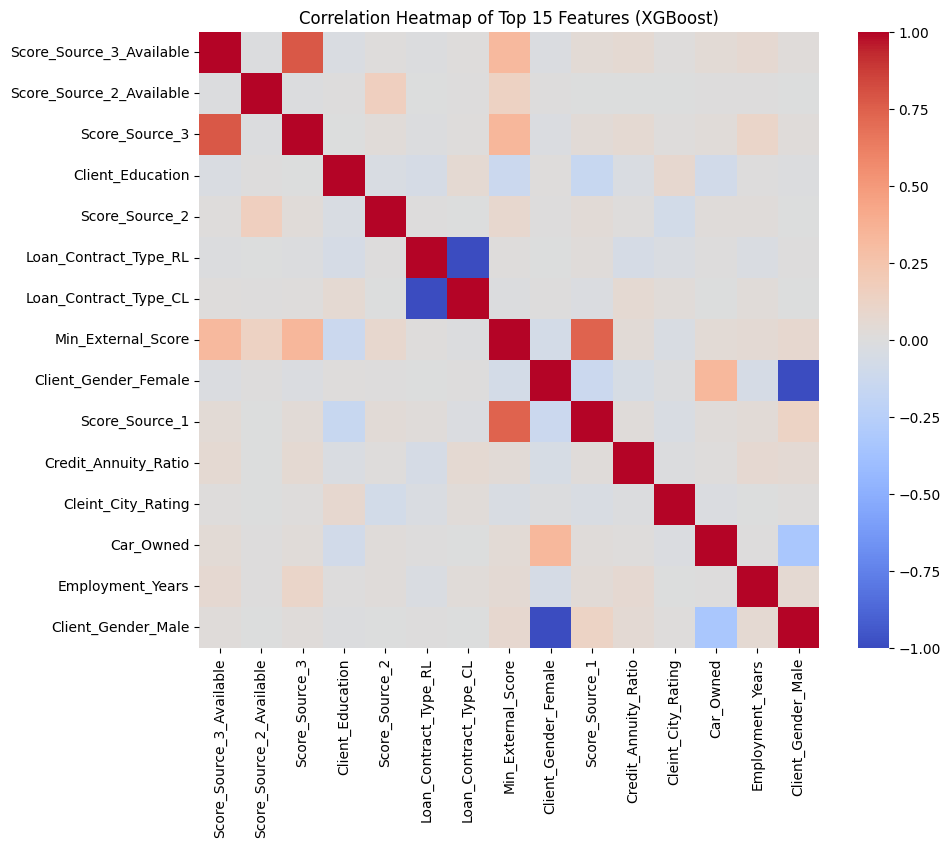

In [6]:
plt.figure(figsize=(10,8))
sns.heatmap(X_train[xgb_importance.head(15)['Feature']].corr(), annot=False, cmap='coolwarm')
plt.title("Correlation Heatmap of Top 15 Features (XGBoost)")
plt.show()
